### Import Necessary Package

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
#from scipy.misc import imread
from IPython import display
from PIL import Image
from skimage.transform import rescale
%matplotlib inline

In [3]:
import os
import cv2
from tqdm import tqdm

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

### Data Pre-Processing

Get image from the directory.

In [23]:
REBUILD_DATA = True

class EISType():
    
    MD = "Nyquist/Missing" # Determine the number of type and then give the directory of each type of image
    SP = "Nyquist/SinglePeak"
    TP = "Nyquist/TwoPeaks"
    # TL = "Nyquist/Tail"
    LABELS = {MD:0, SP:1, TP:2 }
    training_data = []
    mdcount = 0
    spcount = 0
    tpcount = 0
    #tlcount = 0
    
    def make_training_data(self):
        for label in self.LABELS: #iterate the directory
            print(label)
            for f in tqdm(os.listdir(label)): # iterate all the image within the directory, f -> the file name
                path = os.path.join(label, f) # get the full path to the image
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # convert the iimage to gray scale (optional)
                #img = cv2.resize(img, (self.IMG_SIZE*3, self.IMG_SIZE))
                img = rescale(img, 0.15)
                #if img == None:
                    #pass
                self.training_data.append([np.array(img), np.eye(3)[self.LABELS[label]]])                 

                if label == self.MD:
                    self.mdcount += 1
                elif label == self.SP:
                    self.spcount += 1
                elif label == self.TP:
                    self.tpcount += 1
                #elif label == self.TL:
                    #self.tlcount += 1    
                
        np.random.shuffle(self.training_data)
        np.save("eis_training_data.npy", self.training_data)
        print("Missing:", self.mdcount)
        print("SinglePeak:", self.spcount)
        print("TwoPeaks:", self.tpcount)
        #print("Tail:", self.tlcount)
        
if REBUILD_DATA:
    Type = EISType()
    Type.make_training_data()
    


Nyquist/Missing


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.98it/s]


Nyquist/SinglePeak


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.04it/s]


Nyquist/TwoPeaks


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.12it/s]


Missing: 5
SinglePeak: 40
TwoPeaks: 40


*Load the data to check if all the images have been loaded into the program.*

In [24]:
training_data = np.load("eis_training_data.npy", allow_pickle = True)

In [25]:
print(training_data.shape)
print(training_data[1][0].shape)

(85, 2)
(134, 336)


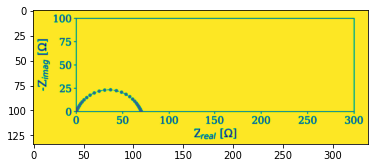

In [26]:
plt.imshow(training_data[1][0])
plt.show()

### CNN Model

In [27]:
class Net(nn.Module):
    
    def __init__(self, input_size, hidden_size, kernel_size, output_size):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(input_size, hidden_size, kernel_size) 
        self.conv2 = nn.Conv2d(hidden_size, hidden_size*2, kernel_size)
        self.conv3 = nn.Conv2d(hidden_size*2, hidden_size*4, kernel_size)
        self.conv4 = nn.Conv2d(hidden_size*4, hidden_size*8, kernel_size)
        
        self.fc1 = nn.Linear(7296, 64) 
        self.fc2 = nn.Linear(64, output_size)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2,2))
        
        xF = x.view(-1, 64 * 19 * 6 ) # flatten
        output = F.relu(self.fc1(xF)) # put into the first fully connected layer
        output = self.fc2(output)
        
        return F.softmax(output, dim=1)

<font color='red'>**Try to use sigmoid function rather than hte ReLU at the last linear layer.** </font>

In [28]:
net = Net(1, 8, 3, 3)
print(net)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=7296, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)


### Separate the training data and testing data

In [29]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 134, 336)
#X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.2 # 20% for Testing
val_size = int(len(X)*VAL_PCT)
print(val_size)

17


In [30]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print("Training Sample:", len(train_X))
print("Testing Sample:", len(test_X))

Training Sample: 68
Testing Sample: 17


### Import the Optimizing and Loss Function

In [31]:
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

In [36]:
BATCH_SIZE = 10
EPOCHS = 6

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 134, 336)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.27it/s]


tensor(3.4243e-07, grad_fn=<MseLossBackward>)


In [37]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 134, 336))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
            
        total += 1
        
print("Accuracy:", round(correct/total,3))

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 42.14it/s]


Accuracy: 0.941
